In [1]:
import os
import math
import numpy as np
import time
import cv2
import matplotlib.pyplot as plt
from PIL import Image

seed = 1234
np.random.seed(seed)

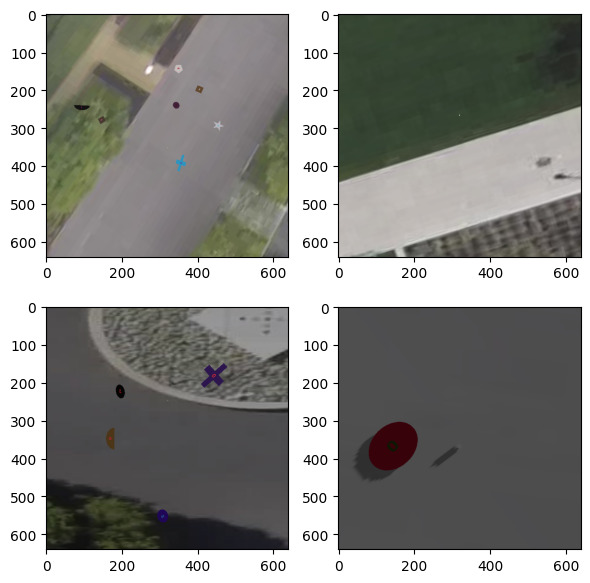

In [2]:
# Example of input images

image1 = np.asarray(Image.open('/kaggle/input/forge-4000/4000_all_labels/train/images/0.png'))
image2 = np.asarray(Image.open('/kaggle/input/forge-4000/4000_all_labels/train/images/10.png'))
image3 = np.asarray(Image.open('/kaggle/input/forge-4000/4000_all_labels/train/images/100.png'))
image4 = np.asarray(Image.open('/kaggle/input/forge-4000/4000_all_labels/train/images/1000.png'))

fig, axis = plt.subplots(2, 2, figsize=(6, 6))
axis[0][0].imshow(image1)
axis[0][1].imshow(image2)
axis[1][0].imshow(image3)
axis[1][1].imshow(image4)

plt.tight_layout()
plt.show()

In [3]:
print(image1.shape)

(640, 640, 3)


In [4]:
train_images_folder = '/kaggle/input/forge-4000/4000_all_labels/train/images'
train_images = [os.path.join(root, filename) for root, dirs, files in os.walk(train_images_folder) for filename in files]
print('train size: '+str(len(train_images)))

train_labels_folder = '/kaggle/input/forge-4000/4000_all_labels/train/labels'
train_labels = [os.path.join(root, filename) for root, dirs, files in os.walk(train_labels_folder) for filename in files]

valid_images_folder = '/kaggle/input/forge-4000/4000_all_labels/valid/images'
valid_images = [os.path.join(root, filename) for root, dirs, files in os.walk(valid_images_folder) for filename in files]
print('valid size: '+str(len(valid_images)))

valid_labels_folder = '/kaggle/input/forge-4000/4000_all_labels/valid/labels'
valid_labels = [os.path.join(root, filename) for root, dirs, files in os.walk(valid_labels_folder) for filename in files]

test_images_folder = '/kaggle/input/forge-4000/4000_all_labels/test/images'
test_images = [os.path.join(root, filename) for root, dirs, files in os.walk(test_images_folder) for filename in files]
print('test size: '+str(len(test_images)))

test_labels_folder = '/kaggle/input/forge-4000/4000_all_labels/test/labels'
test_labels = [os.path.join(root, filename) for root, dirs, files in os.walk(test_labels_folder) for filename in files]

train size: 2800
valid size: 800
test size: 400


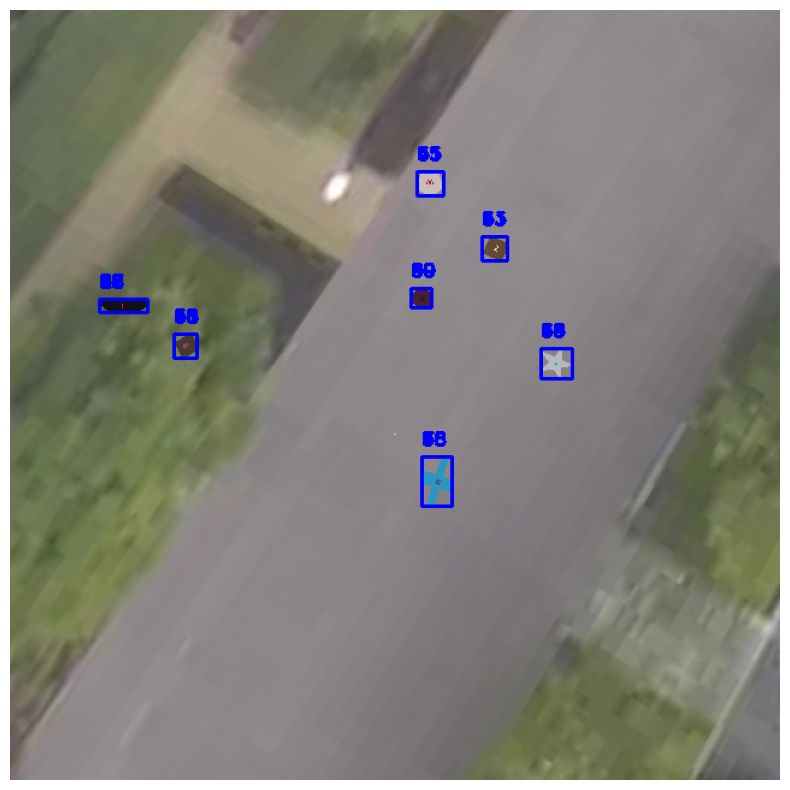

In [5]:
# Load image
image_path = '/kaggle/input/forge-4000/4000_all_labels/train/images/0.png'
image = cv2.imread(image_path)
image_height, image_width = image.shape[:2]

# Read labels.txt file
labels_path = '/kaggle/input/forge-4000/4000_all_labels/train/labels/0.txt'
bounding_boxes = []

with open(labels_path, 'r') as file:
    for line in file:
        parts = line.strip().split()
        label = int(parts[0])
        x_center, y_center, width, height = map(float, parts[1:])
        
        # Convert normalized coordinates to pixel values
        x_center = int(x_center * image_width)
        y_center = int(y_center * image_height)
        width = int(width * image_width)
        height = int(height * image_height)
        
        # Calculate top-left corner of bounding box
        x_min = int(x_center - width / 2)
        y_min = int(y_center - height / 2)
        
        # Store bounding box with label
        bounding_boxes.append((label, x_min, y_min, width, height))

# Draw bounding boxes on image
for label, x_min, y_min, width, height in bounding_boxes:
    # Draw rectangle (bounding box)
    cv2.rectangle(image, (x_min, y_min), (x_min + width, y_min + height), (255, 0, 0), 2)
    # Put label above the bounding box
    cv2.putText(image, str(label), (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

# Display the image with bounding boxes
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [6]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
from torchvision import tv_tensors

In [7]:
class ForgeDataset(Dataset):
    def __init__(self, images_folder, labels_folder, transform=None):
        self.images_folder = images_folder
        self.labels_folder = labels_folder
        self.transform = transform
        
        # List all images and labels
        self.image_files = sorted([os.path.join(root, filename) 
                                   for root, _, files in os.walk(images_folder) 
                                   for filename in files if filename.endswith('.png')])
        
        self.label_files = sorted([os.path.join(root, filename) 
                                   for root, _, files in os.walk(labels_folder) 
                                   for filename in files if filename.endswith('.txt')])
        
        # Sanity check to ensure the dataset is matched properly
        assert len(self.image_files) == len(self.label_files), "Number of images and labels do not match."

    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # Load image
        image_path = self.image_files[idx]
        image = Image.open(image_path).convert("RGB")
        
        # Load label
        label_path = self.label_files[idx]
        boxes = []
        with open(label_path, 'r') as f:
            for line in f.readlines():
                # Each line: class_id, x, y, width, height
                values = line.strip().split()
                class_id = int(values[0])
                x_center = float(values[1])
                y_center = float(values[2])
                width = float(values[3])
                height = float(values[4])
                
                # Add box as a tuple (class_id, x_center, y_center, width, height)
                boxes.append([class_id, x_center, y_center, width, height])
        
        # Convert boxes to tensor
        boxes = torch.tensor(boxes, dtype=torch.float32)
        
        # Apply any image transformations (if provided)
        if self.transform:
            image = self.transform(image)
        
        return image, boxes

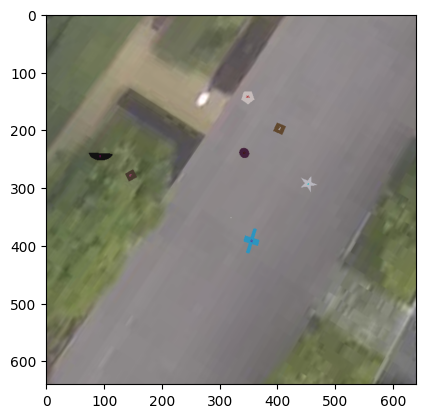

In [8]:
# Transformations
H, W = 640,640
img = np.asarray(Image.open('/kaggle/input/forge-4000/4000_all_labels/train/images/0.png'))

boxes = torch.randint(0, H // 2, size=(3, 4))
boxes[:, 2:] += boxes[:, :2]
boxes = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=(H, W))

transform = v2.Compose([
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),  # Convert images to PyTorch tensors
    v2.RandomResizedCrop(size=(64, 64), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomRotation(degrees=(0, 360)),
    v2.RandomGrayscale(p=1),
    v2.RandomInvert(p=0.5),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

pil_image = v2.ToPILImage()(img)
plt.imshow(pil_image)
plt.show()

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/functional/_type_conversion.py:14: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  output = torch.from_numpy(np.atleast_3d(inpt)).permute((2, 0, 1)).contiguous()


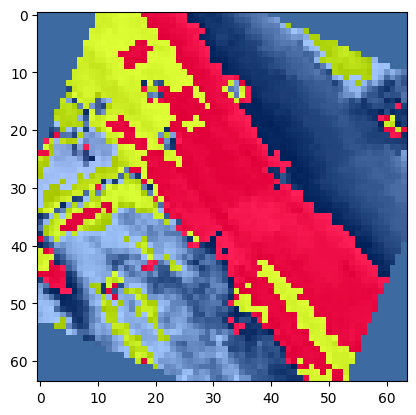

In [9]:
transformed_img = transform(img)
pil_image = v2.ToPILImage()(transformed_img)
plt.imshow(pil_image)
plt.show()

In [10]:
# Paths to the folders
train_images_folder = '/kaggle/input/forge-4000/4000_all_labels/train/images'
train_labels_folder = '/kaggle/input/forge-4000/4000_all_labels/train/labels'

# Initialize Dataset
train_dataset = ForgeDataset(images_folder=train_images_folder, labels_folder=train_labels_folder, transform=transform)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)

In [11]:
print(len(train_loader))
# number of batches (images/batch_size)

88


In [12]:
# !pip install ultralytics

In [13]:
# from ultralytics import YOLO

# # Load a model
# model = YOLO("yolo11n.pt")

# # Train the model
# train_results = model.train(
#     data="/kaggle/input/forge-4000/4000_all_labels/data.yaml",  # path to dataset YAML
#     epochs=1,  # number of training epochs
#     imgsz=640,  # training image size
#     device="cpu",  # device to run on, i.e. device=0 or device=0,1,2,3 or device=cpu
# )

# # Evaluate model performance on the validation set
# metrics = model.val()

# # Perform object detection on an image
# results = model("/kaggle/input/forge-4000/4000_all_labels/valid/images/2800.png")
# results[0].show()

# # Export the model to ONNX format
# path = model.export(format="onnx")  # return path to exported model